# BioPAL Polarimetric Change Analysis Tutorial

The BIOMASS Product Algorithm Laboratory (BioPAL) hosts official tools for processing and analysing ESA\'s BIOMASS mission data.

-   Website: www.biopal.org
-   Mailing: <biopal@esa.int>

_Disclamer:
this tutorial is released under MIT license, it is experimental and may change without notice._


## Tutorial Objective

In this tutorial, following topics will be discussed:
- requirements, biopal installation and environment preparation for this notebook to work
- perform a polarimetric change analysis between two images and generate the p_inc and p_dec Pauli RGB images [1] of the increasing and decreasing polarization states


## References

[1] [A. Alonso-González, C. López-Martínez, K. P. Papathanassiou and I. Hajnsek, "Polarimetric SAR Time Series Change Analysis Over Agricultural Areas," in IEEE Transactions on Geoscience and Remote Sensing, vol. 58, no. 10, pp. 7317-7330, Oct. 2020, doi: 10.1109/TGRS.2020.2981929.](https://ieeexplore.ieee.org/document/9057507)


## Requirements

- The installation procedure described here makes use of the open-source package management system [conda](https://docs.conda.io/projects/conda/en/latest/).
- Python >=3.6


## Installation and Jupyter Notebook Execution


1.  Download and unzip the current [BioPAL distribution](https://github.com/BioPAL/BioPAL) to your local hard drive.


2.  In a *conda* command window, enter in the directory where the BioPAL has been unzipped, and type the following instruction, which creates a biopal environment ( `environment.yml` is present into the main folder of BioPAL distribution ):
	
        conda env create --file environment.yml

3.  In the same *conda* command window, type the following instruction, which activates the created biopal environment:
	
        conda activate biopal

4.  In the same *conda* command window, install Jupyter notebook 
	
        conda install -c conda-forge jupyterlab

5.  In the same *conda* command window, open this Jupyter Notebook typing the following instructions:

        cd doc/Notebooks
        jupyter notebook
        

# Setup BioPAL environment


## Main Ingredients

Main ingredients needed to run this tutorial:

-   `BioPAL/biopal/conf/Configuration_File.xml`: is the BioPAL configuration file (this tutorial is focused on the AGB only)

-   `BioPAL/inputs/Input_File.xml`: input file, to be set by the user before running an instance of the processing

This Notebook is supposed to be executed from `BioPAL/biopal/doc/Notebooks/BioPAL.ipynb`.

Setup of the AGB processor includes:
-   Input File check / preparation
-   Configuration File check / preparation


## BioPAL datasets

BioPAL gives easy access to several datasets that are used for examples in the documentation and testing. These datasets are hosted on the MAAP and must be downloaded for use. Contact <biopal@esa.int> to receive access to the dataset and for more information.
Each dataset is composed by two folders:
-   `dataSet`: folder containing L1 stacks of coregistered and calibrated SLC (Single Look Complex) data
-   `auxiliary_data_pf`: folder containing auxiliary products which are related to each particular dataSet

Note: This example uses the `demo_lope_fd` synthetic dataset to test forest disturbance


## Prepare Input

Open the `inputs/Input_File.xml` and focus on the following sections:

-   `output_specification` section: 
   * `output_folder`: full path of the folder where processing will save the products. Each run will generate a new sub-folder tagged with the processing time stamp (only in case of single run of the complete suite, see later section)
-   `dataset_query` section:
   * `L1C_repository`: should be put equal to the `dataSet` folder described above
   * `L1C_date`start and stop values to select L1 products, in UTC format
   * `auxiliary_products_folder`: should be put equal to the `auxiliary_data_pf` folder described above
   * `geographic_boundaries_polygon`: a set of 3 or more latitude-longitude points describing a polygon used to select L1 products

Note: the Input_File.xml in the repository is already filled with example values. Usually only the folders have to be changed to match the local paths in order to execute this notebook.



# Run the Polarimetric Change Analysis

In this example only the core functions for the Forest Disturbance module will be employed, which implement the polarimetric change analysis described in [[1]](https://ieeexplore.ieee.org/document/9057507/), and are located in the processing_FD package.


The first step is to add the `biopal` folder to the Python path.
In the following code, it is supposed to have this notebook in `BioPAL/biopal/doc/Notebooks/BioPAL.ipynb`
If this is not the case, you can manually set the `biopal_path` in the following example:


In [1]:
from pathlib import Path
import sys
import os

# Get the biopal folder path, supposing that we are in the working directory "biopal/doc/Notebooks/"
notebook_working_dir = Path.cwd()
biopal_path = str(notebook_working_dir.parent.parent)
if biopal_path not in sys.path:
    sys.path.append(biopal_path)

# Try an import to verify the python path
try:
    from biopal.__main__ import biomassL2_processor_run
    
    print('The BioPAL path "{}" has been succesfully added to the python path'.format(biopal_path))

except Exception:
    raise Exception( 'The BioPAL Notebook needs to be executed from the folder "BioPAL/doc/Notebooks" and the "biopal" environment should be enabled too. It has been executed from "{}" instead.'.format(notebook_working_dir) )

The BioPAL path "C:\Users\alon_al\biomass\BioPAL" has been succesfully added to the python path


### dataset_query run

The `dataset_query`, is in charge of getting from the `L1C_repository` only the stacks matching the specified temporal and geographical region of interest. 

It takes as input the `inputs\Input_File.xml` path, prepared in the above steps of this tutorial.

The input file will be updated adding the new section `stack_based_processing` needed to the following APP.
The updated input file will be saved into the output folder.

In [2]:
input_path = str( Path.home().joinpath( biopal_path, "inputs", "Input_File.xml") ) 
from biopal.dataset_query.dataset_query import dataset_query

# Initialize dataset query APP (no configuration file needed in this case)
dataset_query_obj = dataset_query()

# Run dataset query APP
print('Query started...')
input_path_from_query, _, _  = dataset_query_obj.run( input_path )

print('The Input_File has been updated with the new section "stack_based_processing" and saved to {}'.format(input_path_from_query))

Query started...
Query completed.
The Input_File has been updated with the new section "stack_based_processing" and saved to D:\bout\InputFile_StackBasedProcessingFD.xml


In [3]:
from biopal.io.xml_io import parse_input_file

# read the updated input file:
input_params_obj = parse_input_file(input_path_from_query)

# get the new section stack_based_processing:
stack_based_processing_obj = input_params_obj.stack_based_processing

# read the IDs of the stacks found from the query:
found_stack_ids = stack_based_processing_obj.stack_composition.keys()
print('SLC SAR images (slant range geometry) stacks and acquisitions found from the query')
for stack_id, acquisition_ids in stack_based_processing_obj.stack_composition.items():
    print('\n    Stack:')
    print('    ', stack_id)
    print('        Acquisitions:')
    for acq_id in acquisition_ids:
        print('        ', acq_id)
dataSet_path = input_params_obj.dataset_query.L1C_repository
print('\n The above stacks with the acquisitions can be found at following path:\n {}'.format( dataSet_path ))


SLC SAR images (slant range geometry) stacks and acquisitions found from the query

    Stack:
     GC_02_H_320.00_RGSW_00_RGSBSW_00_AZSW_00
        Acquisitions:
         GC_02_H_320.00_RGSW_00_RGSBSW_00_AZSW_00_BSL_00
         GC_02_H_320.00_RGSW_00_RGSBSW_00_AZSW_00_BSL_01
         GC_02_H_320.00_RGSW_00_RGSBSW_00_AZSW_00_BSL_02

    Stack:
     GC_04_H_320.00_RGSW_00_RGSBSW_00_AZSW_00
        Acquisitions:
         GC_04_H_320.00_RGSW_00_RGSBSW_00_AZSW_00_BSL_00
         GC_04_H_320.00_RGSW_00_RGSBSW_00_AZSW_00_BSL_01
         GC_04_H_320.00_RGSW_00_RGSBSW_00_AZSW_00_BSL_02

 The above stacks with the acquisitions can be found at following path:
 D:\data\biopal\demo_lope_fd\dataSet


### Understanding the results

The previous result shows two different stacks corresponding to different cycles (`GC_02` and `GC_04`) with three different acquisitions each one, corresponding to different baselines (`BSL_00`, `BSL_01` and `BSL_02`)

### Loading the data

We can load the data from the first baseline of each stack and generate a Pauli RGB for each of the images corresponding to the first baseline:

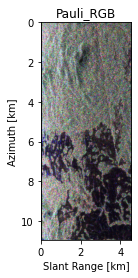

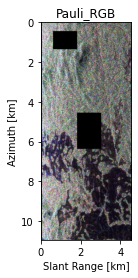

In [4]:
# plots
from arepytools.io.productfolder import ProductFolder
import numpy as np
from matplotlib import pyplot as plt

dataSet_path = input_params_obj.dataset_query.L1C_repository
imgs = []
for stack_id, acquisition_ids in stack_based_processing_obj.stack_composition.items():
    acq_id = acquisition_ids[0]
    # Getting Pauli of the SLC
    slc_pf_path = Path.home().joinpath( dataSet_path, acq_id)
    pf = ProductFolder( slc_pf_path,'r' )
    # Channel order: (HH, HV, VH, VV)
    w = []
    for channel_to_read in range(4):
        w.append(pf.read_data( channel_to_read ))
    # Generate Pauli basis
    wp = []
    wp.append((w[0] + w[3])/np.sqrt(2)) # Pauli 1
    wp.append((w[0] - w[3])/np.sqrt(2)) # Pauli 2
    wp.append((w[1] + w[2])/np.sqrt(2)) # Pauli 3
    # Convert wp to numpy array with pol. in the last axis
    wp = np.transpose(np.asarray(wp), axes=(1,2,0))
    imgs.append(wp)
    # Free w memory
    w = None

    # Change Pauli channels to match classical representation:
    # RGB = Pauli 2, Pauli 3, Pauli 1
    pauli_rgb = np.abs(wp)[...,(1,2,0)]
    # Scale each axis independently (for better visualization only)
    channel_means = np.mean(pauli_rgb, axis=(0,1))
    pauli_rgb = pauli_rgb / channel_means
    f_mean = 2.5
    # Scale Pauli from 0 to f_mean * mean
    pauli_rgb = np.clip(pauli_rgb, 0, f_mean) / f_mean

    # for the axis
    data_channel_obj = pf.get_channel( channel_to_read )
    metadata_obj = data_channel_obj.metadata
    metadatachannel_obj = metadata_obj.get_metadata_channels(0)
    ri = metadatachannel_obj.get_element("RasterInfo")
    range_length_km = ri.samples*ri.samples_step/1000
    azimuth_length_km = ri.lines*ri.lines_step /1000 
    # plot 
    plt.figure()
    plt.imshow( pauli_rgb, origin='upper',
                extent=[ 0, range_length_km, azimuth_length_km, 0])
    plt.xlabel('Slant Range [km]')
    plt.ylabel('Azimuth [km]')
    plt.title('Pauli_RGB')


### Understanding the results

As it may be seen, this is a synthetic dataset where the second image is exactly the same as the first image except on two squares where the data has been removed, appearing in black on the second image.

### Generating covariance matrices

The next step is to generate and estimate the cherency matrices of both images `T1` and `T2` and apply a multilook:

In [5]:
from scipy.ndimage.filters import uniform_filter

# Generate covariance matrices
T1 = np.einsum('...i,...j->...ij', imgs[0], imgs[0].conj())
# Perform multilook
ml = [15,5]
# NOTE: uniform_filter does not support complex numbers,
# then it is applied to real & imginary parts
T1.real = uniform_filter(T1.real, size=ml + [1, 1], output=T1.real)
T1.imag = uniform_filter(T1.imag, size=ml + [1, 1], output=T1.imag)

T2 = np.einsum('...i,...j->...ij', imgs[1], imgs[1].conj())
# Perform multilook
T2.real = uniform_filter(T2.real, size=ml + [1, 1], output=T2.real)
T2.imag = uniform_filter(T2.imag, size=ml + [1, 1], output=T2.imag)


### Performing the generalized eigendecomposition

Having the covariance matrices for both images, we can perform the generalized eigendecomposition with the functions present in the BioPAL library:

In [7]:
from biopal.fd.processing_FD import generalized_eigendecomp

# Compute the generalized eigendecomposition between T1 and T2
# NOTE: This might take some time...
W, V = generalized_eigendecomp(T1, T2)

print("Done!")

Done!


`W` contains the (sorted) generalized eigenvalues and `V` the generalized eigenvectors.
This functions works similarly to `numpy.linalg.eig` but it computes the generalized eigendecomposition between the two given matrices instead.

This information is related to the optimization of polarimetric contrast between the images and it can be employed to analyze the polarimetric change, as described in [[1]](https://ieeexplore.ieee.org/document/9057507/).

In the following, we plot the three generalized eigenvectors in dB:

Text(0.5, 1.0, 'Lambda_3 [dB]')

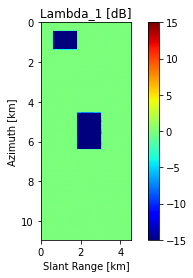

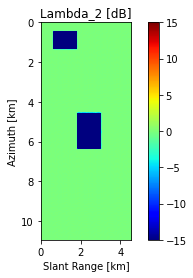

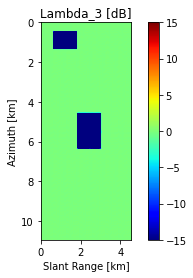

In [8]:
plt.figure()
plt.imshow(10*np.log10(W[...,0]), vmin=-15, vmax=15, cmap='jet', origin='upper',
                extent=[ 0, range_length_km, azimuth_length_km, 0])
plt.colorbar()
plt.xlabel('Slant Range [km]')
plt.ylabel('Azimuth [km]')
plt.title('Lambda_1 [dB]')

plt.figure()
plt.imshow(10*np.log10(W[...,1]), vmin=-15, vmax=15, cmap='jet', origin='upper',
                extent=[ 0, range_length_km, azimuth_length_km, 0])
plt.colorbar()
plt.xlabel('Slant Range [km]')
plt.ylabel('Azimuth [km]')
plt.title('Lambda_2 [dB]')

plt.figure()
plt.imshow(10*np.log10(W[...,2]), vmin=-15, vmax=15, cmap='jet', origin='upper',
                extent=[ 0, range_length_km, azimuth_length_km, 0])
plt.colorbar()
plt.xlabel('Slant Range [km]')
plt.ylabel('Azimuth [km]')
plt.title('Lambda_3 [dB]')


### Understanding the results

The first (lambda_1) and third (lambda_3) correspond to the minimum and maximum polarimetric contrast, respectively.

In this case, since there is no change over most of the image, all of them are equal to 0dB (in green) in the images.

However, over the squares where there is missing data a a large negative value (in dB) is observed in all the eigenvalues, appearing in dark blue color, indicating a strong decrease in all polarizations.

### Generating the p_inc and p_dec images

For an easier visualization of the changes and the corresponding polarization states, the p_inc and p_dec Pauli RGB images were proposed in [[1]](https://ieeexplore.ieee.org/document/9057507/).
We can compute them also with the functions of the BioPAL library:

Text(0.5, 1.0, 'Decreasing Pauli_RGB')

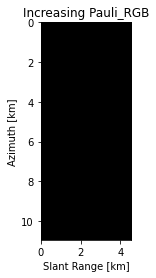

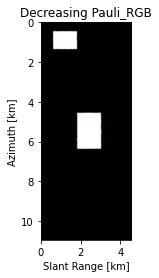

In [9]:
from biopal.fd.processing_FD import generate_pinc_pdec_RGBimages

# Generate increasing and decreasing images
pinc, pdec = generate_pinc_pdec_RGBimages(W, V)

# Plot increasing Pauli RGB image
plt.figure()
plt.imshow( pinc, origin='upper',
            extent=[ 0, range_length_km, azimuth_length_km, 0])
plt.xlabel('Slant Range [km]')
plt.ylabel('Azimuth [km]')
plt.title('Increasing Pauli_RGB')

# Plot decreasing Pauli RGB image
plt.figure()
plt.imshow( pdec, origin='upper',
            extent=[ 0, range_length_km, azimuth_length_km, 0])
plt.xlabel('Slant Range [km]')
plt.ylabel('Azimuth [km]')
plt.title('Decreasing Pauli_RGB')

### Understanding the results

On these images the intensity represents the magnitude of the change while the color represents the polarization states that change, according to the Pauli RGB representation.

As it may be seen, nothing appears on the increasing image (p_inc) as there are no regions which are increasing between the two images.

On the decrease image (p_dec) only the squares appear in white color, since they are the only changing areas of the image. In this case, the white color is obtained as the change is an unrealistically strong decrease in all polarizations which saturates the representation.